In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

### Simulating a waveform given an obstacle

In [41]:
Nmics = 64
Nsamp = 200
src = (0,0)
pitch = 0.1
dist_per_samp = 0.1
C = 2.0
obstacle = (3, -1)
SincP = 5.0  #####
mics = []

In [42]:
if Nmics%2 == 0:
    for i in range(-Nmics//2, Nmics//2, 1):
        y_coord = (i) * pitch + pitch / 2
        if y_coord == 0:
            continue
        mics.append(y_coord)
else: 
    for i in range(-(Nmics//2), Nmics//2 + 1, 1):
        y_coord = (i) * pitch
        mics.append(y_coord)

In [43]:
print(len(mics), mics)

64 [-3.1500000000000004, -3.0500000000000003, -2.95, -2.8500000000000005, -2.7500000000000004, -2.6500000000000004, -2.5500000000000003, -2.45, -2.3500000000000005, -2.2500000000000004, -2.1500000000000004, -2.0500000000000003, -1.95, -1.85, -1.75, -1.6500000000000001, -1.55, -1.45, -1.35, -1.25, -1.1500000000000001, -1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35000000000000003, -0.25000000000000006, -0.15000000000000002, -0.05, 0.05, 0.15000000000000002, 0.25, 0.35000000000000003, 0.45, 0.55, 0.6500000000000001, 0.7500000000000001, 0.8500000000000001, 0.9500000000000001, 1.05, 1.1500000000000001, 1.2500000000000002, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.7500000000000002, 1.85, 1.9500000000000002, 2.05, 2.15, 2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15]


In [44]:
def wsrc(t):
    return np.sinc(SincP * t)
time = [i * dist_per_samp for i in range(Nsamp)]

In [45]:
#plt.plot(t, w)

In [46]:
def dist(src, pt, mic):
    d1 = math.sqrt( (src[0] - pt[0])**2 + (src[1] - pt[1])**2 )
    d2 = math.sqrt( (mic[0] - pt[0])**2 + (mic[1] - pt[1])**2 )
    return d1 + d2

In [47]:
def get_output_of_one_mic(src, obs, mic, dist_per_samp, time):
    dist_till_mic = dist(src, obs, [0, mic])
    delay = dist_till_mic - time[0]
    return [wsrc(t - delay) for t in time]

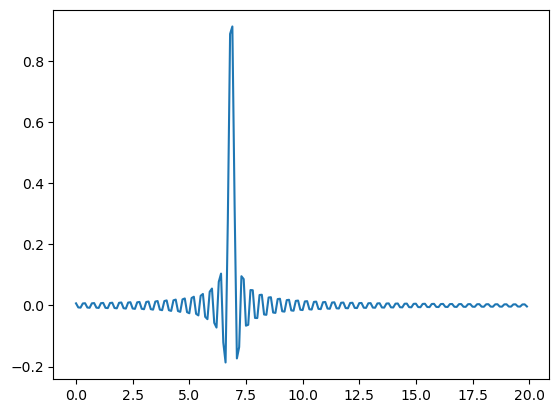

In [48]:
mic1 = get_output_of_one_mic(src, obstacle, mics[0], dist_per_samp, time)
plt.plot(time, mic1)

In [49]:
def get_output(src, obstacle, mics, dist_per_samp, time, Nmics):
    output = []
    for i in range(Nmics):
        output.append(get_output_of_one_mic(src, obstacle, mics[i], dist_per_samp, time))
    return output

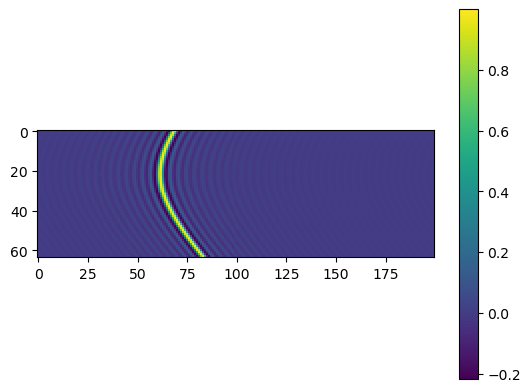

In [78]:
matrix = get_output(src, obstacle, mics, dist_per_samp, time, Nmics)

plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add color bar to indicate scale

plt.show()

### Predicting the position of an obstacle based on the response recieved.

In [93]:
matrix = np.loadtxt('rx2.txt')
matrix.shape

(64, 200)

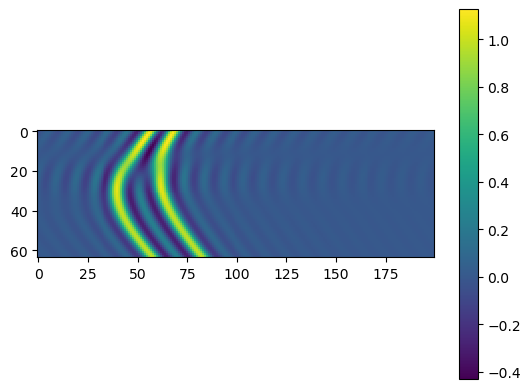

In [94]:
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add color bar to indicate scale

plt.show()

In [99]:
summed_amplitudes = np.zeros((100, 100))

In [102]:
# Scaling factors
peak_scaling_factor = 2.0  # Increase peaks by a factor of 2
low_offset = -0.5           # Decrease lows by 0.5

for i in range(summed_amplitudes.shape[0]):
    for j in range(summed_amplitudes.shape[1]):
        x = i * dist_per_samp
        y = -5 + j * pitch
        
        aligned_signals = np.zeros(Nsamp)
        
        for mic_idx in range(len(mics)):
            signal = matrix[mic_idx]
            delay = dist( src, (x, y), [0, mics[mic_idx]] )
#             print(delay)
            delay_idx = int(np.round(delay / (C * dist_per_samp)))
            if delay_idx < len(signal):
                delayed_signal = np.concatenate((signal[delay_idx : ], np.zeros(delay_idx)))
#                 print(mic_idx, delay_idx)
            else:
                delayed_signal = np.zeros_like(signal)
                
            aligned_signals += delayed_signal# * peak_scaling_factor + low_offset
        
        summed_amplitudes[j][i] = np.max(np.abs(aligned_signals)) / Nmics

print(src, (x, y))

(0, 0) (9.9, 4.9)


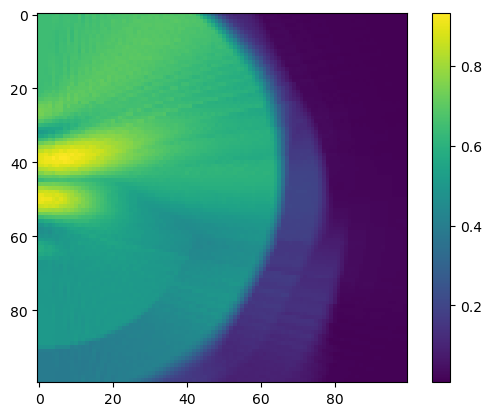

In [103]:
plt.imshow(summed_amplitudes, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add color bar to indicate scale

plt.show()

In [107]:
def DAS(mic_outputs, grid_size_x, grid_size_y):
    reconstruction = np.zeros((grid_size_y, grid_size_x))

    for j, mic_y in enumerate(mics):
        for x in range(grid_size_x):
            for y in range(grid_size_y):
                pt = (x * dist_per_samp, (y - grid_size_y // 2) * pitch)
                d_total = dist(src=(0, 0), pt=pt, mic=[0, mic_y])
                delay = d_total / C
                sample_delay = int(np.round(delay / dist_per_samp))
                
                if sample_delay < Nsamp:
                    reconstruction[y][x] += mic_outputs[j][sample_delay]
                else:
                    reconstruction[y][x] += 0
    
    return reconstruction


In [108]:
output = DAS(matrix, 100, 100)
output.shape

(100, 100)

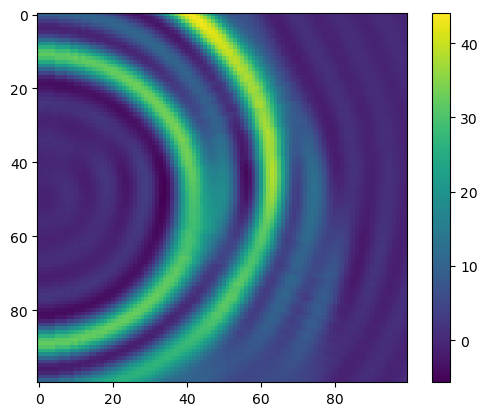

In [109]:
plt.imshow(output, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add color bar to indicate scale

plt.show()